# Titanic Survival Analysis and Prediction

## Model development using sklearn - Parker Allen

![titanic_custom-fc6a03aedd8e562d780ecf9b9a8a947d4dcbf163-s1100-c50](titanic_custom-fc6a03aedd8e562d780ecf9b9a8a947d4dcbf163-s1100-c50.jpg)


This study will dive into the statistical relationship between the class, sex, age, number of siblings, number of parents/children, ticket, fare, cabin, and embarking location of passengers aboard the Titanic and their survival rate. The ultimate goal is to discover a highly accurate model with an ROC AUC (Receiver Operating Characteristic Area Under the Curve) score of at least 0.95. After cleaning the data and generating a knowledgeable understanding through exploratory data analysis, different machine-learning models will be tested against each other to find the most optimal predictor of survival. While cleaning the data, assumptions will be implicitly made on whether categorical data should be ordinal or continuous, with ordinal data utilizing a label encoder and continuous data being dummified.  

In [259]:
# Import libraries and data while setting basic seaborn style and palette
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

seed = 2097
sns.color_palette('pastel')
sns.set_style('dark')
df = pd.read_csv('train.csv')
testdf = pd.read_csv('test.csv')
testyvals = pd.read_csv('gender_submission.csv')
testdf['Survived'] = testyvals['Survived']

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Survived         0
dtype: int64


## Data Cleaning

### Detect Missing Values

In [260]:
print(df.isna().sum())
print("Although the dataframe has ", len(df), " columns, there are ", df['Cabin'].isna().sum(), "mising Cabin values")     

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Although the dataframe has  891  columns, there are  687 mising Cabin values


### Clean Missing Values

Based on the data, not having a cabin is likely a significant part of the data, so the likely course of action is to make a category for the missing data.

177


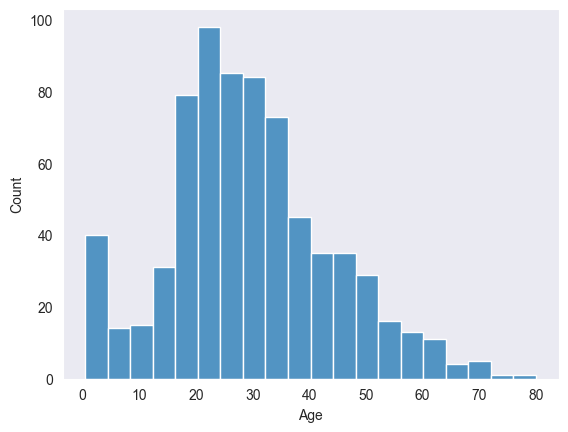

In [261]:
df['Cabin'] = df['Cabin'].fillna(0).astype('category')
# df.isna().sum()

sns.histplot(x='Age', data=df)
print(df['Age'].isna().sum())

Moving onto age, age is a significant factor in determining the survival rate of a passenger. Therefore, the best course of action is to drop the data altogether or replace the values with ages normalized to the data without the missing values. However, replacing the normalized values with the data may provide an incorrect estimation since the 177 values, if included, may significantly alter age distribution. However, I will opt for this strategy since the general passengers of the titanic were statistically younger, which matches the distribution above. To accomplish this, I will use a linear regression model using 'Survived', 'Pclass', 'SibSp', 'Fare', and 'Embarked' to estimate the ages of the passengers. Finally, I will drop all missing rows from the 'Embarked' column since there are only two missing values.

In [262]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

# Create Data Cleaning and Preparatory Functions for Later Use
def clean_data(df): 
    columnorder = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived']
    df = df[columnorder]
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    df['Cabin'] = df['Cabin'].fillna(0).astype('category')
    age_predict_features = df[['Survived','Pclass','SibSp', 'Fare', 'Embarked', 'Age']].dropna(subset=['Age'],axis=0)
    age_predict_features['Embarked'] = age_predict_features['Embarked'].astype('category')
    age_dummified_features = pd.get_dummies(age_predict_features, columns=['Embarked'])
    X_age = age_dummified_features.drop('Age', axis=1)
    y_age = age_dummified_features['Age']
    # X_trainage, X_testage, y_trainage, y_testage = train_test_split(Xage, yage, test_size=0.2)

    age_model = LinearRegression()
    # age_model.fit(X_trainage, y_trainage) Root Mean Squared Error of 12.74
    # y_predage = age_model.predict(X_testage)
    # print(MSE(y_predage, y_testage)**(1/2))

    missing_age_set = df[df['Age'].isna() == True]
    missing_ageX = missing_age_set[['Survived','Pclass','SibSp', 'Fare', 'Embarked']]
    missing_ageX['Embarked'] = missing_ageX['Embarked'].astype('category')
    missing_ageX = pd.get_dummies(missing_ageX, columns=['Embarked'])

    age_model.fit(X_age, y_age)
    new_ages = age_model.predict(missing_ageX)

    missing_ageX['Age'] = new_ages
    missing_ages = missing_ageX.copy()['Age']

    df_dropped = df.dropna(subset=['Age'], axis=0)["Age"]
    df['Age'] = df_dropped.append(missing_ages)
    df['Age'] = df['Age'].round(0).astype('int')
    df = df.dropna(axis=0)
    return df

def prepdata(df): 
    df.set_index('PassengerId')
    y_vals = df['Survived']
    
    le = LabelEncoder()

    X_features = df.drop(['Name','Ticket', 'Survived'], axis=1)
    X_features = pd.get_dummies(X_features, columns=['Sex', 'Embarked'])
    X_features['Cabin'] = X_features['Cabin'].astype('str') 
    X_features['Cabin'] = le.fit_transform(X_features['Cabin'])
    
    return X_features, y_vals

df = clean_data(df)
testdf = clean_data(testdf)
print(df.isna().sum())

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Survived       0
dtype: int64


Now that the data has been cleaned and machine learning prepreprocessing functions have been created, it is time to take a closer look at the data.

## Exploratory Data Analysis

### Distribution Insight

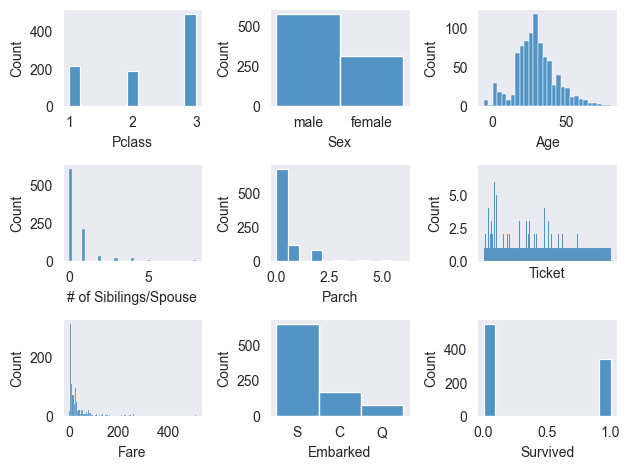

In [263]:
fig, ax = plt.subplots(3, 3)
dataviz = df.drop(['PassengerId', 'Name', 'Cabin'], axis=1)
dataviz = dataviz.rename(columns={'SibSp':"# of Sibilings/Spouse"})

for i in range(len(df)):
    if i <= 2: 
        sns.histplot(dataviz.iloc[:, i], ax=ax[0,i])
    elif i <= 5: 
        sns.histplot(dataviz.iloc[:, i], ax=ax[1,(i-3)])
    elif i <= 8: 
        sns.histplot(dataviz.iloc[:, i], ax=ax[2, (i-6)])
    else: 
        pass
ax[1,2].set_xticks([])

plt.tight_layout()
plt.show()

At first glance, it is clear that many data features are skewed. First, more people died or went missing after/during the events of the Titanic than the population that survived. Next, looking at the passenger class (or Pclass) of the population and noting that the tier of the passenger class reduces from 1 to 3, it is clear that there was a substantially higher amount of lower class (3rd class) than second or first class passengers. This should be noted, as the higher class passengers historically had increased access to rafts during the disaster. Moving on, although it can be deduced that there were more men than women on the Titanic, so far, it is unclear whether gender had an impact on the survival of the passengers.
On the contrary, it is known that younger individuals have higher chances of surviving disasters, so the younger distribution of passengers on the ship should be taken into account. When considering the amount of siblings a passenger has in addition to their spouse, it should be noted that having family onboard the ship would likely drive many to act in a selfless manner that would lead to their death on the boat. Furthermore, the number of parents/children aboard (Parch) should be noted similarly, as many parents act selflessly to protect their children. Compared to the other variables, the ticket has the most uninteresting distribution, almost entirely even. Succeeding, the fare of the tickets (in British pounds) is likely linked to the passenger class of each individual, giving even more weight to the socioeconomic status of each individual. It must be noted that S in the embarked graph signifies that the passenger embarked from Southampton to understand the data above, C means that they embarked from Cherbourg, and Q signals that they embarked from Queenstown. In the graph, it is clear that an overwhelming majority of passengers embarked from Queenstown.

### Statistical Relationships

<AxesSubplot: xlabel='Pclass', ylabel='Survived'>

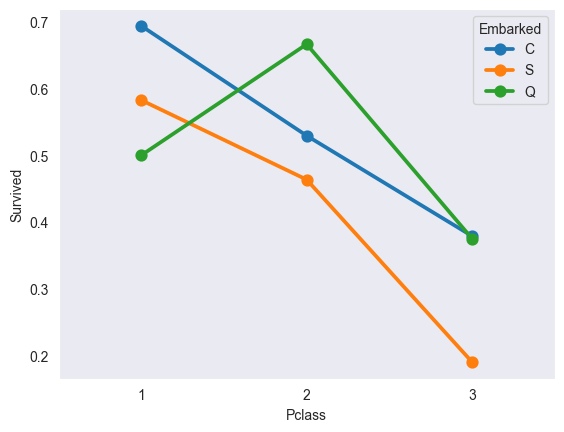

In [264]:
sns.pointplot(data=df, x='Pclass', y='Survived', hue='Embarked', ci=None)

This illustration makes it incredibly apparent that passengers in the first or second class have a distinct advantage over the third class, with the third class having a significantly lower survival rate than the others. Although it is difficult to tell whether the embarked city affected the survival, it is apparent that passengers from Southampton had a lower chance of surviving the disaster across the board, especially when in the third passenger class. 

<AxesSubplot: xlabel='Parch', ylabel='Survived'>

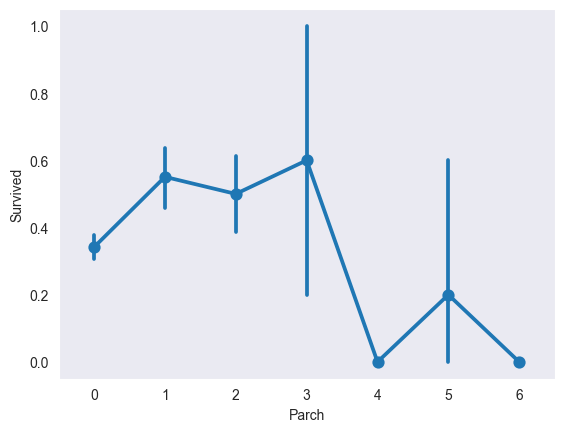

In [265]:
sns.pointplot(data=df, x='Parch', y='Survived')

The data above does not give a completely readable statistical relationship. The error bars between 1 to 2 parents/children aboard prove that their difference is statistically insignificant. However, the sudden dip in survival rate once 4-6 parents/children is reached should be noted. 

<AxesSubplot: xlabel='Sex', ylabel='Survived'>

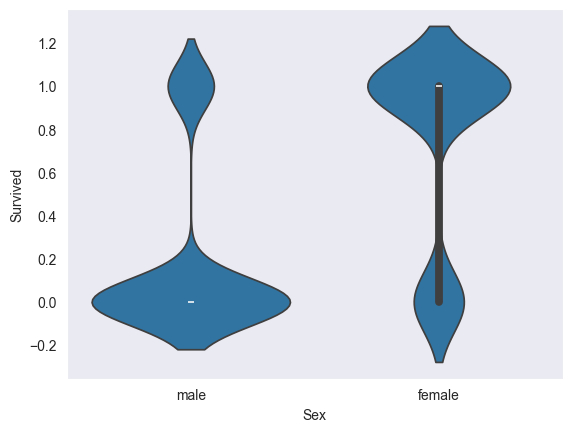

In [266]:
sns.violinplot(x='Sex', y='Survived', data=df)

Males, as shown in this diagram, had a significantly lower chance of surviving than women did. There is a clear inversely related bias between genders in terms of survival.

<AxesSubplot: xlabel='Fare', ylabel='Survived'>

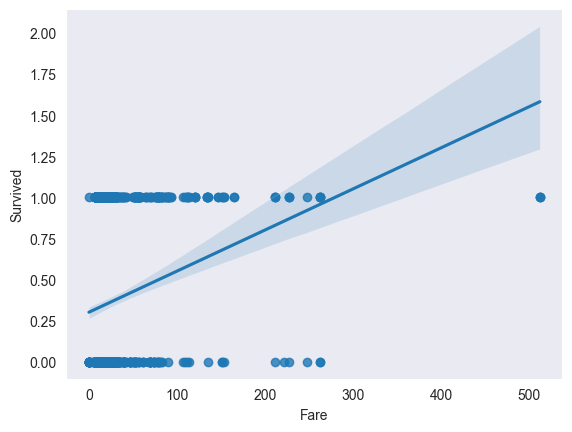

In [267]:
sns.regplot(x='Fare', y='Survived', data=df)

Although the plot is slightly difficult to read, it is able to be inferred with reasonable confidence that individuals with lower fares had a far lower chance of surviving than those who spent more. At around 300 pounds in fare, it becomes almost guarenteed for the passenger to survive, compared to the around 25% chance for passengers who paid next to nothing. 

<AxesSubplot: xlabel='Age', ylabel='Survived'>

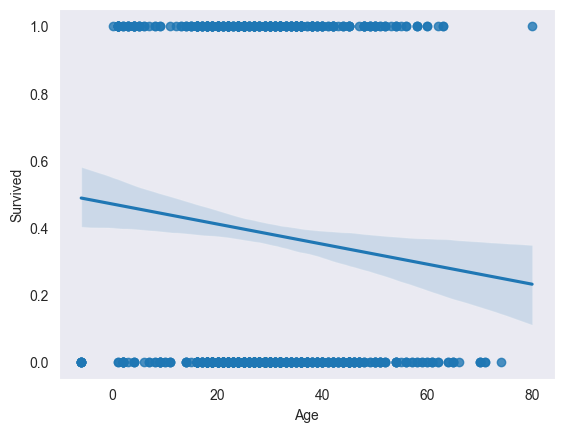

In [268]:
sns.regplot(x='Age', y='Survived', data=df)

Lastly, in accordance with our predictions, the rate of survival decreases as the age of an individual decreases

## Model Development

### Logistic Regression

In [269]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

X, y = prepdata(df)
modelLog = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

modelLog.fit(X, y)
# logy_pred = modelLog.predict(X_test)
# print(roc_auc_score(logy_pred, y_test))

X_testdf, y_testdf = prepdata(testdf)
y_predtest = modelLog.predict(X_testdf)
print("The logistic regression classification model achieved a ROC AUC score of: ", roc_auc_score(y_testdf, y_predtest), ", and an accuracy score of: ", accuracy_score(y_predtest, y_testdf))

The logistic regression classification model achieved a ROC AUC score of:  0.9609962406015038 , and an accuracy score of:  0.9593301435406698


The logistic regression model had an extremely accurate ability to predict the survival or a passenger, with a ROC AUC (Receiver operating characteristic area under the curve model) score of 0.9642. This score demonstrates extreme accuracy, with a score of 1 reflecting perfect accuracy. However, it is yet to be determined if there are models that can better represent the survival of the passengers.   

In [270]:
# Import and instantiate Naive Bayes Gaussian 
from sklearn.naive_bayes import GaussianNB

NBmodel = GaussianNB()
NBmodel.fit(X, y)
NBypred = NBmodel.predict(X_testdf)
print("The naive bayes gaussian model achieved a ROC AUC score of:", roc_auc_score(NBypred, y_testdf), ", and an accuracy score of: ", accuracy_score(NBypred, y_testdf))

The naive bayes gaussian model achieved a ROC AUC score of: 0.919582399433762 , and an accuracy score of:  0.930622009569378


Though the accuracy and ROC AUC scores for the naive bayes gaussian model still demonstrates a strong ability to predict whether passengers, its accuracy lacks in comparison to the Logistic model. 

### Nearest Neighbors Model

In [271]:
# Import and instantiate KNeigbors model
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import GridSearchCV

KModel = KNN(n_jobs=-1, algorithm='auto', leaf_size=50, n_neighbors=5, p=1)
# Kparam_grid = {'n_neighbors':np.arange(1,10), 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size':np.arange(10,50,5), 'p':[1,2]}
# clf = GridSearchCV(estimator=KModel, param_grid=Kparam_grid, error_score=1, n_jobs=-1)
# clf.fit(X_train, y_train)
# print(clf.best_params_) Best parameters were: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1}, but I adjusted the parameters manually to get a better score
KModel.fit(X, y)
Kypred = KModel.predict(X_testdf)
print('The KNeighbors classifier achieved a roc auc score of:', roc_auc_score(y_testdf, Kypred), 'and an accuracy score of:', accuracy_score(y_testdf, Kypred))

The KNeighbors classifier achieved a roc auc score of: 0.5559210526315789 and an accuracy score of: 0.6483253588516746


The KNeighbors Classifier had a significantly lower accuracy than the other models, with a fairly weak roc auc score and accuracy score. Since its roc auc score is below 0.7, it should not be considered in any predictions.

### Gaussian Model

In [272]:
from sklearn.gaussian_process import GaussianProcessClassifier
GPModel = GaussianProcessClassifier(random_state=seed, n_jobs=-1)
GPModel.fit(X, y)
ypredGP = GPModel.predict(X_testdf)
print("The gaussian process had a roc auc score of:", roc_auc_score(ypredGP, y_testdf), "and an accuracy score of:", accuracy_score(ypredGP, y_testdf))

The gaussian process had a roc auc score of: 0.8189448441247003 and an accuracy score of: 0.638755980861244


With a relatively decent roc auc score, but a low accuracy score, it can be proven that the Gaussian Classifier boasts a moderate ability to predict survivial in the Titanic dataset. 

### Random Forest Model

In [274]:
from sklearn.ensemble import RandomForestClassifier

RFmodel = RandomForestClassifier(n_jobs=-1, max_depth=400, min_samples_leaf=0.1, n_estimators=200, random_state=seed)
# RFparam_grid = {'n_estimators':np.arange(50,300,50), 'max_depth':np.arange(50,500,50), 'min_samples_leaf':[0.0001,0.001,0.01,0.1,0.15,0.2,0.25,0.3,0.4], 'max_features':['sqrt', 'log2', None]}
# clf = GridSearchCV(estimator=RFmodel, param_grid=RFparam_grid, error_score=1, n_jobs=-1)
# clf.fit(X, y)
# print(clf.best_params_)  
# Best features {'max_depth': 400, 'max_features': None, 'min_samples_leaf': 0.01, 'n_estimators': 200}. However, better score after changing to 0.1 min samples leaf
RFmodel.fit(X, y)
RFypred = RFmodel.predict(X_testdf)
print('The random forest model had a roc auc score of:', roc_auc_score(RFypred, y_testdf), "and an accuracy score of:", accuracy_score(RFypred, y_testdf))

0.9962686567164178 0.9952153110047847


With an outstanding roc auc score and accuracy score, it is safe to assume that the random forest model is a highly accurate method of estimating the survival of the passengers aboard the Titanic. For future use, here are the parameters of the random forest model: n_jobs=-1, max_depth=400, min_samples_leaf=0.1, n_estimators=200, random_state=2097. Thus, the random forest model proved to be the best estimator for binary classification of the titanic dataset compared to the performance of the KNeighbors classifier, Naive Bayes model, Gaussian model, and Logistic Regression model. While concluding that the random forest model was the best method in this study, different classification models, such as a neural network model, may have a more accurate ability to predict survival. 